<a href="https://colab.research.google.com/github/SamuelMiller413/Deep-Learning-Course/blob/main/DL_8_Introduction_to_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre Processing

In [ ]:
!pip install torchmetrics attrdict -q

     |████████████████████████████████| 419 kB 5.0 MB/s 


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from IPython.display import display
from attrdict import AttrDict
from multiprocessing import cpu_count


In [ ]:
# Maybe delete this. Not sure if I want to get into GPUs yet, that should be a separate lesson.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Load the train and validation data
mnist_train = pd.read_csv('sample_data/mnist_train_small.csv', header=None, dtype="float32")
mnist_valid = pd.read_csv('sample_data/mnist_test.csv', header=None, dtype="float32")

In [ ]:
# Take a look at the data.
# It looks like the first column is the label,
# And columns 1 - 785 are pixels.
print(mnist_train.shape)
mnist_train.head()

(20000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.11215

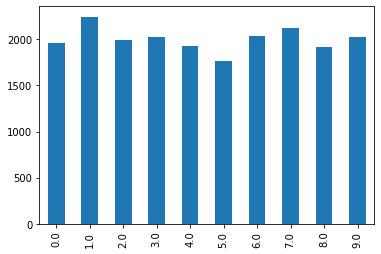

In [ ]:
# What's the distribuiont of labels in the train set?
display(mnist_train[0].value_counts().sort_index().plot.bar())
display(mnist_train[0].value_counts(normalize=True).max())

0.11215

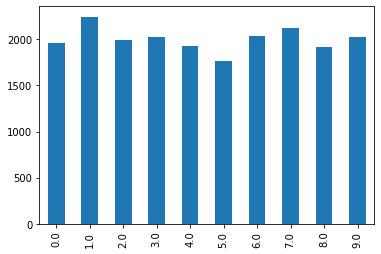

In [ ]:
# What's the distribuion of labels in the validation set?
display(mnist_train[0].value_counts().sort_index().plot.bar())
display(mnist_train[0].value_counts(normalize=True).max())

In [ ]:
def show_number(row, ax=None):
    """
    This function shows a row as an image, and titles it with the label.
    
    Options:
    * row: a row from either of the mnist_train or mnist_valid dataframes.
    * ax: if not None, will plot the digit on the provided ax.
        Otherwise, this function should create a figure and 
    """
    return_fig = ax == None
    target, values = row.values[0], row.values[1:].reshape(28, 28)
    if not ax:
        fig, ax = plt.subplots()
    ax.imshow(values, cmap='gray_r')
    ax.set_title(target)
    
    plt.close()
    if return_fig:
        return fig

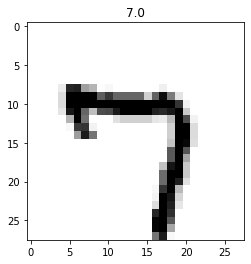

In [ ]:
show_number(mnist_train.sample(1).iloc[0])

In [ ]:
def show_many(n_rows=3, n_cols=3):
    """
    This function shows a number of images at a time, by default 9.
    It takes a random sample of (n_rows * n_cols) of the training data to show.
    """
    # Sample the training data
    train_df_sample = mnist_train.sample(n_rows * n_cols)
    # Create the figure
    fig = plt.figure(figsize=(4*n_cols, 4*n_rows))
    # For each row in the sample, plot the number
    for i, (_, row) in enumerate(train_df_sample.iterrows()):
        ax = fig.add_subplot(n_rows, n_cols, 1+i)
        show_number(row, ax)
    plt.close()
    return fig

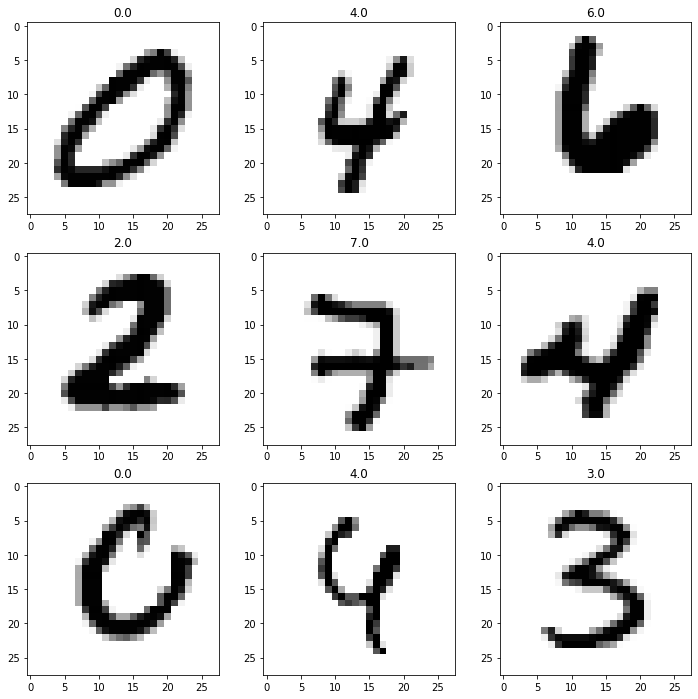

In [ ]:
show_many()

In [ ]:
# What are the min and max values of the data?
mnist_train.loc[:, 1:].values.max(), \
mnist_train.loc[:, 1:].values.min()

(255.0, 0.0)

In [ ]:
type(mnist_train.loc[1,2])

numpy.float32

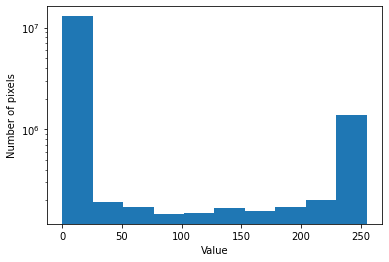

In [ ]:
plt.hist(mnist_train.loc[:, 1:].values.ravel())
plt.ylabel('Number of pixels')
plt.xlabel('Value')
plt.yscale('log')

In [ ]:
# Let's scale all the data between 0 and 1.
mnist_train_scaled = mnist_train.copy()
mnist_train_scaled.loc[:, 1:] /= 255

In [ ]:
mnist_valid_scaled = mnist_valid.copy()
mnist_valid_scaled.loc[:, 1:] /= 255

In [ ]:
mnist_train_scaled.loc[:, 1:].values.max(), \
mnist_train_scaled.loc[:, 1:].values.min()

(1.0, 0.0)

In [ ]:
print(mnist_train_scaled.shape)
a=0
b=0


for i in range(10):
    a += i
    print(
        type(mnist_train_scaled.loc[a,b]),
        "",
        "ghost",
        "",
        mnist_train_scaled.loc[a,b]
    )  

(20000, 785)
<class 'numpy.float32'>  ghost  6.0
<class 'numpy.float32'>  ghost  5.0
<class 'numpy.float32'>  ghost  9.0
<class 'numpy.float32'>  ghost  0.0
<class 'numpy.float32'>  ghost  2.0
<class 'numpy.float32'>  ghost  9.0
<class 'numpy.float32'>  ghost  4.0
<class 'numpy.float32'>  ghost  3.0
<class 'numpy.float32'>  ghost  7.0
<class 'numpy.float32'>  ghost  4.0


In [ ]:
# # creating a DataFrame
# data = {'1' : ['g', 'e', 'e'], 
#         '2' : ['k', 's', 'f'], 
#         '3' : ['o', 'r', 'g'], 
#         '4' : ['e', 'e', 'k']}
# df = pd.DataFrame(data)
# print("Original DataFrame")
# display(df)
  
# print("Value of row 1")
# display(df.iloc[1])

# Exercise 8.1

Now that we've preprocessed our data, we require objects to feed data to our model.
Using your knowledge about `torch` datasets, complete the `MnistDataset` class.
Your `__getitem__` method should return a tuple of two values - the first is a vector of lenth 784 representing the pixel values of the image, and the second is an integer representing the label (0-9).
Both items should be of type `torch.Tensor`.

<!-- startquestion -->


In [ ]:
class MnistDataset(Dataset):
    
    def __init__(self, x):
        super().__init__()
        self.x = x
      
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        row = self.x.iloc[idx][1:].to_numpy(dtype="float32")
        label = self.x[0][idx]
        return torch.tensor(row, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

#alt
    # def __getitem__(self, idx):
    #     row = self.x.iloc[idx, 1:].values
    #     label = self.x.iloc[idx, 0]
    #     return torch.tensor(row, dtype=float32), torch.tensor(label, dtype=float32)

# getitem:
# 1. vector/tensor of length 784 (row) -> ds.iloc[idx] 
# 2. Label (0-9) ((tensor)) -> ds[0]
# Return: Tuple. (row, label)


In [ ]:
# try_out = torch.tensor(mnist_train_scaled.loc[0], dtype=float)
# try_out[1:].shape

In [ ]:
# Create datasets from the dataframes
train_ds = MnistDataset(mnist_train_scaled)
valid_ds = MnistDataset(mnist_valid_scaled)

In [ ]:
# print(train_ds)

In [ ]:
# x, y = train_ds[0]
# y

In [ ]:
# thing = mnist_train_scaled[1][1:].to_numpy(dtype="float32")
# print(thing)
# print(type(thing))
# print(thing.dtype)
# print()
# print()
# thing = torch.tensor(thing, dtype=torch.float32)
# print(thing)
# print(type(thing))
# print(thing.dtype)

In [ ]:
# a, b = (6,7,8)
# a

In [ ]:
# Sanity check!
_x, _y = train_ds[0]  
assert _x.shape[0] == mnist_train_scaled.shape[1] - 1
assert _y == mnist_train_scaled.loc[0,0]

# Exercise 8.2

Now that we've created our datasets, use them to create our train and validation dataloaders.
Remember to shuffle your train dataloader but not your valid!

<!-- startquestion -->

## Preparing Pipeline

In [ ]:
BATCH_SIZE = 32
N_WORKERS = cpu_count() 

In [ ]:
# Create dataloaders from the datasets.
# During the training phase, we need to keep both the activations 
# and the gradients in memory. However during the validation phase,
# we don't have to store gradients so we can double the batch size!

train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=N_WORKERS
)

valid_dl = DataLoader(
    valid_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=N_WORKERS
)

In [ ]:
# # FROM SECTION 2 ON SEQUENTIAL:
# def multilayer_regressor(in_dim, hidden_dim):
#     return nn.Sequential(
#         nn.Linear(in_dim, hidden_dim),
#         nn.ReLU(),
#         MultiLayerRegressor(hidden_dim, hidden_dim),
#         nn.ReLU(),
#         # nn.Linear(hidden_dim, hidden_dim),
#         # nn.ReLU(),
#         # nn.Linear(hidden_dim, hidden_dim),
#         # nn.ReLU(),
#         # nn.Linear(hidden_dim, hidden_dim),
#         # nn.ReLU(),
#         nn.Linear(hidden_dim, 1),
#     )

In [ ]:
def linear(in_features:int, out_features:int, dropout=0.2):
    """
    Returns an nn.Sequential module that we want to repeat a lot.
    The module contains a linear layer, ReLU activation, BatchNorm, and dropout.
    """
    seq_mod = nn.Sequential(    
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(p=dropout, inplace=True)         
            )
    return seq_mod
    raise NotImplementedError


# Alternate the order of the models layer:
# def linear(in_features, out_features, dropout=0.2):

#     seq_mod_alt = nn.Sequential(    
#             nn.Linear(in_features, out_features),
#             nn.ReLU(),
#             nn.BatchNorm1d(out_features),
#             nn.Dropout(p=dropout, inplace=True)         
#             )
#     return seq_mod_alt 
    


In [ ]:
# Sanity check!
assert len(linear(1,1)) == 4

In [ ]:
# Define some parameters for the model
class Config(AttrDict):
    def __init__(self, num_input_features=28*28, n_hidden_layers=2, hidden_dim=256, n_labels=10):
        self.num_input_features = num_input_features
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.n_labels = n_labels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()

### classifier should *start* with a 
linear module with 
<br/>config.num_input_features inputs 
<br/>and 
<br/>config.hidden_dim outputs
### <br/>followed by 
config.n_hidden_layers hidden layers, 
<br/> >>keeping the dimensionality of the actvations constant
### <br/>Finally
nn.Linear layer that takes <br/>config.hidden_dim inputs<br/>and<br/>config.n_labels outputs


In [ ]:
config

AttrDict({'num_input_features': 784, 'n_hidden_layers': 2, 'hidden_dim': 256, 'n_labels': 10, 'device': 'cuda'})

In [ ]:
def build_model(config):
    hidden_dim = config.hidden_dim
    # model
    model = nn.Sequential(
        # 1st layer
        linear(in_features=config.num_input_features, out_features=hidden_dim),
        # hidden layers
        linear(in_features=hidden_dim, out_features= hidden_dim),
        linear(in_features=hidden_dim, out_features= hidden_dim),
        # final layer
        nn.Linear(in_features=hidden_dim, out_features=config.n_labels)
    )
    # to device
    print('Model device: ', next(model.parameters()).device)
    if not next(model.parameters()).is_cuda & torch.cuda.is_available():
        print('Model is on CPU, but GPU is available. Putting model on GPU.')
        model = model.to(config.device)
    print('Model device: ', next(model.parameters()).device)

    return model


    raise NotImplementedError()

In [ ]:
# instantiate the model
model = build_model(config)

Model device:  cpu
Model is on CPU, but GPU is available. Putting model on GPU.
Model device:  cuda:0


In [ ]:
type(model)

torch.nn.modules.container.Sequential

In [ ]:
# if the model's not on the GPU but it's available, put it there.
print('Model device: ', next(model.parameters()).device)
if not next(model.parameters()).is_cuda & torch.cuda.is_available():
    print('Model is on CPU, but GPU is available. Putting model on GPU.')
    model = model.to(config.device)
    print('Model device: ', next(model.parameters()).device)

Model device:  cuda:0


In [ ]:
# Sanity check!
assert len(model) == config.n_hidden_layers + 2

In [ ]:
# Another sanity check: our model should be able to operate on a batch of data.
for x_b, y_b in train_dl:
    break

# model(x_b.to(config.device)).shape
model(x_b.to(config.device)).shape


torch.Size([32, 10])

In [ ]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())
metric = torchmetrics.Accuracy()

In [ ]:
# Trying stuff out:

for x_b, y_b in train_dl:
    break
x_b = x_b.to(config.device)
y_b = y_b.to(config.device)
# model(x_b.to(config.device)).shape
yhatz = model(x_b)
# yhatz.type(torch.LongTensor)
loss = loss_func(yhatz, y_b.long())
# gradients
# torch.autograd.set_detect_anomaly(True)
# loss.backward()
grads = torch.gradient(yhatz)
print(grads)
# print(f"x_b = {x_b}")
# print(f"y_b = {y_b}")
# print(f"yhatz = {yhatz}")
# print(f"loss = {loss}")

# Mike's solution

# for x_b, y_b in train_dl:
#     break
# x_b = x_b.to(config.device)
# y_b = y_b.to(config.device)
# # model(x_b.to(config.device)).shape
# yhatz = model(x_b)
# # yhatz.type(torch.LongTensor)
# loss = loss_func(yhatz,y_b.long())
# # print(f"x_b = {x_b}")
# # print(f"y_b = {y_b}")
# # print(f"yhatz = {yhatz}")
# print(f"loss = {loss}")



# # From crossentropyloss doc


# # Example of target with class indices

# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# output.backward()
# 
# # Example of target with class probabilities

# input = torch.randn(3, 5, requires_grad=True)
# target = torch.randn(3, 5).softmax(dim=1)
# output = loss(input, target)
# output.backward()



(tensor([[ 1.0589,  0.1756, -0.0101,  0.1093, -0.3343,  0.0300, -0.3361, -0.2803,
          0.9750, -0.1538],
        [ 0.3540,  0.1898, -0.5068,  0.0250, -0.0049,  0.0055, -0.1669,  0.0389,
          0.0524, -0.2705],
        [-0.4512, -0.2617, -0.3308,  0.3054, -0.0270, -0.0728, -0.1689, -0.0928,
         -0.4818, -0.3897],
        [-0.2056, -0.1753,  0.1802, -0.1757, -0.0167,  0.0371,  0.0427, -0.0748,
         -0.1877,  0.2958],
        [ 0.2379, -0.3647, -0.0823, -0.3968,  0.1496, -0.0137,  0.1145,  0.2743,
          0.0704,  0.6295],
        [ 0.1855,  0.4532, -0.0436,  0.2493, -0.3428, -0.3586, -0.3180, -0.1936,
          0.5862, -0.1616],
        [-0.5963,  0.6206,  0.1198,  0.0014, -0.0064,  0.3827,  0.0120, -0.0689,
          0.3145, -0.3856],
        [-0.4216, -0.7208,  0.3378,  0.0337,  0.4600,  0.2552,  0.1845, -0.1519,
         -0.6031, -0.3690],
        [ 0.5091,  0.0883, -0.0498, -0.0485,  0.0677, -0.0378,  0.0687, -0.6046,
         -0.1520,  0.3189],
        [ 0.7641, 

In [ ]:
def train_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    
    # Generate yhat
    yhat = model(x_b)

    # Calculate the loss
    loss = loss_func(yhatz, y_b.long())

    # Calculate gradients
    loss.backward()
    

    # Perform your update and zero out your gradients
    opt.step()
    opt.zero_grad()

    # Update your accuracy metric. We'll give you this one!
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu())

    # Return the loss
    return loss

In [ ]:
def validation_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    # Tell torch not to calculate gradients on the validation batch
    with torch.no_grad():
        # Generate yhat
        yhat = model(x_b)
        # Calculate the loss
        loss = loss_func(yhatz, y_b.long())

    # Ok, you've seen this before, you do it this time!
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu())

    # Return the loss
    return loss

## Pipeline Script

In [ ]:
# Workers / Batch / Epochs
N_WORKERS = cpu_count() 
BATCH_SIZE = 64 # Batch_Parameter
N_EPOCHS = 12

'''
Life's a Batch    
    Having an Issue With: 
        ValueError:
            'Expected input batch_size (32) to match target batch_size (64)'

            Identify As ->
                input_bs 
                target_bs

    Thoughts:
        An issue within the loss_func 
        Does the loss function encode the input_bs?
        Where is the input_bs encoded?
        Is there something occurring with the linear layer outputs?
            Specify batch size in nn.Linear? ex. [BATCH_SIZE, inp_feats, outp_feats]
    
    What to Explore:
        'Batch_Mark' spots
        Where is target_bs?
        How does softmax come into this? # softmax_mark
    
    What are:
        input_bs    (32)    < This is where the problem is
                &
        target_bs   (BATCH_SIZE)
            
    Where are they being set?
        Target_bs : Batch_Parameter
        
        input_bs
            label smoothing? no
            red
        
        problem occurring:
            with:
                input_bs
            at: 
                loss = train_step(x_b, y_b.int())
                    module
                        loss.py
                            label_smoothing
    
    yhatZ!!
        I hadn't fixed the code fromt the tryout code that included yhatz. This was throwing the batch_size expectations
        I learned a ton while exploring this!                            
'''

# Data Loaders
train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, # Batch_Mark | input_bs | Set by Batch_Parameter
    shuffle=True, 
    num_workers=N_WORKERS
)

valid_dl = DataLoader(
    valid_ds, 
    batch_size=BATCH_SIZE, # Batch_Mark | input_bs | Set by Batch_Parameter
    shuffle=False, 
    num_workers=N_WORKERS
)


# custom linear layer
def linear(in_features:int, out_features:int, dropout=0.2): 
    """
    Returns an nn.Sequential module that we want to repeat a lot.
    The module contains a linear layer, ReLU activation, BatchNorm, and dropout.
    """
    seq_mod = nn.Sequential(    
            nn.Linear(in_features=in_features, out_features=out_features), # Batch_Mark
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
            nn.Dropout(p=dropout)         
            )
    return seq_mod
    raise NotImplementedError


# Config parameters for the model
class Config(AttrDict):
    def __init__(self, num_input_features=28*28, n_hidden_layers=2, hidden_dim=256, n_labels=10):
        self.num_input_features = num_input_features
        self.n_hidden_layers = n_hidden_layers
        self.hidden_dim = hidden_dim
        self.n_labels = n_labels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = Config()


# Model Builder
def build_model(config):
    hidden_dim = config.hidden_dim
    # model
    model = nn.Sequential(
        # 1st
        linear(in_features=config.num_input_features, out_features=hidden_dim),
        # hidden
        linear(in_features=hidden_dim, out_features=hidden_dim),
        linear(in_features=hidden_dim, out_features=hidden_dim),
        # final
        nn.Linear(in_features=hidden_dim, out_features=config.n_labels) # Batch_Mark
    )
# to device
    print('Model device: ', next(model.parameters()).device)
    if not next(model.parameters()).is_cuda & torch.cuda.is_available():
        print('Model is on CPU, but GPU is available. Putting model on GPU.')
        model = model.to(config.device)
    print('Model device: ', next(model.parameters()).device)
    return model
    raise NotImplementedError()


# Instantiate the Model
model = build_model(config)

# Loss / Opt / Metric
loss_func = nn.CrossEntropyLoss()
# opt = torch.optim.Adam(model.parameters())
opt = torch.optim.Adam(model.parameters(), amsgrad=True)
# opt = torch.optim.SGD( model.parameters(), lr=.01)
# opt = torch.optim.Adamax(lr=.02, params=model.parameters())
metric = torchmetrics.Accuracy()


# Steps: Training / Validation
def train_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    # Generate yhat
    yhat = model(x_b)
    # Calculate the loss
    loss = loss_func(yhat, y_b.long()) # Batch_Mark??
    # Calculate gradients
    loss.backward()
    # Perform your update and zero out your gradients
    opt.step()
    opt.zero_grad()
    # Update your accuracy metric
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu()) # Batch_Mark?? | softmax_mark
    # Return the loss
    return loss
    
def validation_step(x_b, y_b):
    # Send x_b and y_b to the GPU, if available
    x_b = x_b.to(config.device)
    y_b = y_b.to(config.device)
    # Tell torch not to calculate gradients on the validation batch
    with torch.no_grad():
        # Generate yhat
        yhat = model(x_b)
        # Calculate the loss
        loss = loss_func(yhat, y_b.long()) # Batch_Mark??
    # Update your accuracy metric
    batch_acc = metric(yhat.cpu().softmax(axis=1), y_b.cpu()) # Batch_Mark?? | softmax_mark
    # Return the loss
    return loss


Model device:  cpu
Model is on CPU, but GPU is available. Putting model on GPU.
Model device:  cuda:0


In [ ]:
# opt
# >>> change amsgrad to 'True' ?
    # with set to true:
    #     no significant change\
    # > come back to this after having worked on whatever is going wrong in general

## Train / Valid Model

In [ ]:
train_losses_step = []
train_losses = []
valid_losses = []
dbug_counter = 1
for epoch in range(N_EPOCHS):
    # Training loop
    model.train() # Put the model in train mode
    train_loss_epoch = 0.
    # print(dbug_counter)
    for x_b, y_b in train_dl:
        dbug_counter += 1
        # print(dbug_counter)
        loss = train_step(x_b, y_b.int())
        train_loss_epoch += loss
        train_losses_step.append(loss.item())
    
    # Compute the train loss and accuracy for the epoch.
    # The epoch loss is a little bit off if our final batch
    # is a different size - we're going to ignore that for now,
    # since higher-level libraries will solve this for us.
    train_loss_epoch /= len(train_dl)
    train_losses.append(train_loss_epoch.item())
    train_acc = metric.compute()
    
    # Validation loop
    model.eval() # Put the model in eval mode (affects dropout and batch norm)
    val_loss_epoch = 0.
    for x_b, y_b in valid_dl:
        loss = validation_step(x_b, y_b.int())
        val_loss_epoch += loss
    
    val_loss_epoch /= len(valid_dl)
    valid_acc = metric.compute()
    valid_losses.append(val_loss_epoch.item())

    print(f"Epoch: {epoch+1}, Train loss: {train_loss_epoch:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss_epoch} Valid Acc: {float(valid_acc):.04f}")

Epoch: 1, Train loss: 0.3833 Train acc: 0.8878, Valid loss: 0.1594621241092682 Valid Acc: 0.9086
Epoch: 2, Train loss: 0.1795 Train acc: 0.9230, Valid loss: 0.1392914056777954 Valid Acc: 0.9286
Epoch: 3, Train loss: 0.1428 Train acc: 0.9357, Valid loss: 0.11468201130628586 Valid Acc: 0.9388
Epoch: 4, Train loss: 0.1181 Train acc: 0.9431, Valid loss: 0.0997760146856308 Valid Acc: 0.9452
Epoch: 5, Train loss: 0.0932 Train acc: 0.9489, Valid loss: 0.09490155428647995 Valid Acc: 0.9504
Epoch: 6, Train loss: 0.0839 Train acc: 0.9529, Valid loss: 0.09958392381668091 Valid Acc: 0.9539
Epoch: 7, Train loss: 0.0761 Train acc: 0.9561, Valid loss: 0.09350833296775818 Valid Acc: 0.9568
Epoch: 8, Train loss: 0.0617 Train acc: 0.9589, Valid loss: 0.09672849625349045 Valid Acc: 0.9594
Epoch: 9, Train loss: 0.0539 Train acc: 0.9611, Valid loss: 0.08813899010419846 Valid Acc: 0.9617
Epoch: 10, Train loss: 0.0530 Train acc: 0.9632, Valid loss: 0.08786246925592422 Valid Acc: 0.9636
Epoch: 11, Train loss:

Text(0.5, 0, 'Epoch')

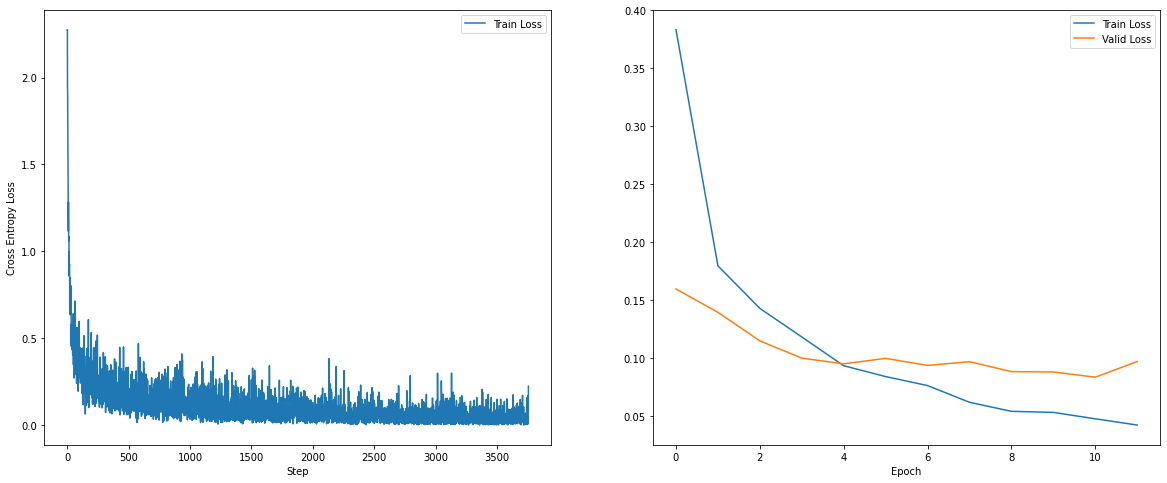

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax1, ax2 = axes
ax1.plot(train_losses_step, label='Train Loss')
ax2.plot(train_losses, label='Train Loss')
ax2.plot(valid_losses, label='Valid Loss')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('Cross Entropy Loss')
ax2.set_xlabel('Epoch')

In [ ]:
def show_preds(sample=None):
    """
    Shows a actuals and inferences from a random sample of the validation dataset.
    """
    # Sample a few images
    if sample is None:
        sample = mnist_valid_scaled.sample(9)
    # Get the sample into a format we can feed into the model
    x_b = torch.FloatTensor(sample.loc[:, 1:].values)
    y_b = sample.loc[:,0].values

    # Make inferences on the sample
    model.eval()
    with torch.no_grad():
        # Get the inferences, apply softmax to convert to predicted probabilities,
        # and use argmax to get the index of the highest probability.
        # This is the digit!
        preds = model(x_b.to(config.device)).softmax(dim=-1).argmax(dim=-1).cpu().numpy()
    
    # Plot a 3x3 grid of digits, where the title
    # contains the predictiona nd the actual value.
    fig = plt.figure(figsize=(12, 12))
    for i, (x, y, p) in enumerate(zip(x_b, y_b, preds)):
        ax = fig.add_subplot(3, 3, 1+i)
        ax.matshow(x.reshape(28, 28), cmap='Greys_r')
        ax.set_title(f'Actual: {y}, Pred: {int(p)}')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.close()
    return fig

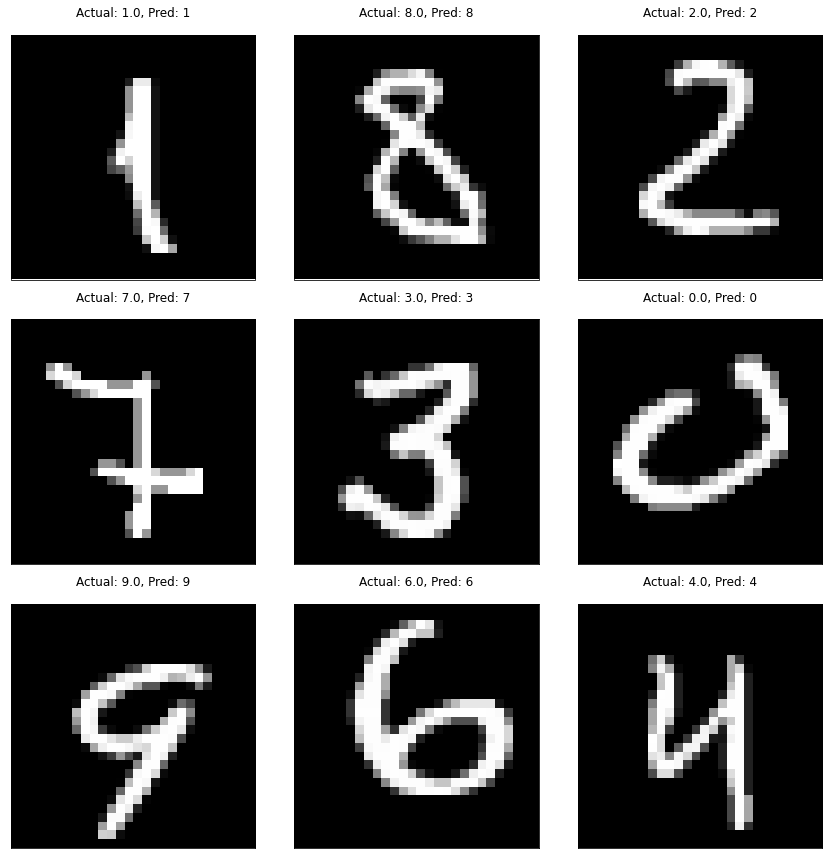

In [ ]:
show_preds()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
probas = []
preds = []
losses = []
ys = []
model.eval()
for x_b, y_b in valid_dl:
    with torch.no_grad():
        logits = model(x_b.to(config.device)).cpu()
        _probas = logits.softmax(dim=-1).numpy()
        _preds = _probas.argmax(axis=-1)
        _losses = F.cross_entropy(logits, y_b.long(), reduce=False)
    probas.append(_probas)
    preds.append(_preds)
    losses.append(_losses.numpy())
    ys.append(y_b.numpy())
probas = np.vstack(probas)
preds = np.concatenate(preds)
losses = np.concatenate(losses)
ys = np.concatenate(ys)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


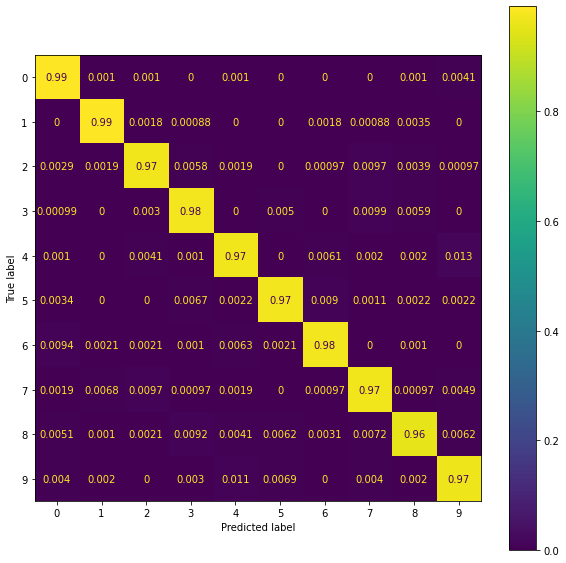

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(ys, preds, normalize='true'), display_labels=range(20))
cm_fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

In [ ]:
print(classification_report(ys, preds))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.98      0.97      0.97      1032
         3.0       0.97      0.98      0.97      1010
         4.0       0.97      0.97      0.97       982
         5.0       0.98      0.97      0.98       892
         6.0       0.98      0.98      0.98       958
         7.0       0.97      0.97      0.97      1028
         8.0       0.98      0.96      0.97       974
         9.0       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Exercise 8.6
What are the items with the highest losses? Are these reasonable errors for the model to make?

In [ ]:
# Your code here!
losses.argsort()
mnist_valid_scaled[732]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    0.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Name: 732, Length: 10000, dtype: float32

In [ ]:
# Mike's Solution
top_loss_indices = losses.argsort()[::-1][:9]
top_losses = mnist_valid_scaled.iloc[top_loss_indices]
show_preds(top_losses)

### Code Explanation
The code in the 1st line `[::-1]` works by calling the indices for every row of loss in descending order.
</br>
Wherea the code `[:9]` retreives the first 9 examples from the sorted losses.
</br>
In the 2nd line `iloc` uses the `top_loss_indices` to pull the `top_losses` from the scaled validation dataset. 
</br>
Finally, calling the `show_preds` function brings up the examples and prints their images.


In [ ]:
mnist_valid_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Extras / Scratch

In [ ]:
# Samuel's

def show_preds(sample=None, sort=False):
    """
    Shows a actuals and inferences from a random sample of the validation dataset.
    """
    # Sample a few images
    if sort is True:
        sorted_losses =losses.argsort()
        print(sorted_losses)

    if sort is False:
        if sample is None:
            sample = mnist_valid_scaled.sample(9)

    # Get the sample into a format we can feed into the model
    x_b = torch.FloatTensor(sample.loc[:, 1:].values)
    y_b = sample.loc[:,0].values

    # Make inferences on the sample
    model.eval()
    with torch.no_grad():
        # Get the inferences, apply softmax to convert to predicted probabilities,
        # and use argmax to get the index of the highest probability.
        # This is the digit!
        preds = model(x_b.to(config.device)).softmax(dim=-1).argmax(dim=-1).cpu().numpy()
    
    # Plot a 3x3 grid of digits, where the title
    # contains the predictiona nd the actual value.
    fig = plt.figure(figsize=(12, 12))
    for i, (x, y, p) in enumerate(zip(x_b, y_b, preds)):
        ax = fig.add_subplot(3, 3, 1+i)
        ax.matshow(x.reshape(28, 28), cmap='Greys_r')
        ax.set_title(f'Actual: {y}, Pred: {int(p)}')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.tight_layout()
    plt.close()
    return fig

In [ ]:
tensor_ex = torch.tensor([[1.5, 0.8, -0.7, 0.5, -1],
                          [1.78, 0.6, 0.134, -0.6, -0.8]])

In [ ]:
tensor_ex[0,:].softmax(dim=0)

tensor([0.4861, 0.2414, 0.0539, 0.1788, 0.0399])

In [ ]:
tensor_ex.softmax(dim=1)

tensor([[0.4861, 0.2414, 0.0539, 0.1788, 0.0399],
        [0.5824, 0.1939, 0.1176, 0.0584, 0.0478]])

In [ ]:
tensor_ex.numpy()[0,:]

array([ 1.5,  0.8, -0.7,  0.5, -1. ], dtype=float32)

In [ ]:
tensor_ex.sum(dim = 1)

tensor([1.1000, 1.1140])

In [ ]:
tensor_ex.numpy().sum(axis=1)

array([1.0999999, 1.       ], dtype=float32)

In [ ]:
tensor_2

tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8]],

        [[ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23],
         [24, 25, 26]]])

In [ ]:
tensor_2 =torch.arange(0,27,1).reshape(3,3,3)

In [ ]:
tensor_2.ndim

3

In [ ]:
tensor_2.sum(dim = 0)

tensor([[27, 30, 33],
        [36, 39, 42],
        [45, 48, 51]])

In [ ]:
tensor_2[:,:,2]

tensor([[ 2,  5,  8],
        [11, 14, 17],
        [20, 23, 26]])